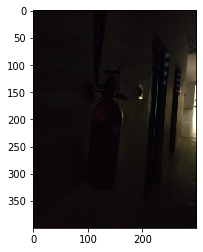

In [198]:
import numpy as np
import cv2
from scipy import sparse
import scipy.sparse.linalg
import sys

%matplotlib inline
import matplotlib.pyplot as plt

raw_image = cv2.imread("t4.jpg")
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,4))
plt.imshow(raw_image)

In [199]:
def LIME(img, alpha = 0.5, epsilon = 0.001, weight_strategy = 1, sigma = 2, kernel_size = 5, gamma = 0.8):
    img = img / 255
    T_hat = np.max(img, axis = 2)
    m, n = T_hat.shape
    
    delT_hatx = calculate_del(T_hat, 'x')
    delT_haty = calculate_del(T_hat, 'y')
    
    if weight_strategy == 1:
        wx = np.ones((m, n))
        wy = np.ones((m, n))
        #print(wx.shape, wy.shape)
    elif weight_strategy == 2:
        wx = 1 / (np.abs(delT_hatx) + epsilon)
        wy = 1 / (np.abs(delT_haty) + epsilon)
        #print(wx.shape, wy.shape)
    elif weight_strategy == 3:
        gaussian_kernelx = cv2.getGaussianKernel(kernel_size, sigma).reshape(1, -1)
        gaussian_kernely = gaussian_kernelx.reshape(-1, 1)
        gaussianX = cv2.filter2D(delT_hatx, ddepth = -1, kernel = gaussian_kernelx)
        gaussianY = cv2.filter2D(delT_haty, ddepth = -1, kernel = gaussian_kernely)
        
        g = np.sum(gaussian_kernelx)
        wx = g / (gaussianX + epsilon)
        wy = g / (gaussianY + epsilon)
        
    wx = wx / (np.abs(delT_hatx) + epsilon)
    wy = wy / (np.abs(delT_haty) + epsilon)
        
    T = solve_Eqn(wx, wy, 0.5, T_hat)
    
    T = np.power(T, gamma)
    #print(T[0])
    img2 = np.empty((m, n, 3))
    img2[:, :, 0] = T
    img2[:, :, 1] = T
    img2[:, :, 2] = T
    
    r = img / (img2 + epsilon)
    
    r = r * 255
    r = np.clip(r, 0, 255)
    r = np.fix(r).astype(np.uint8)
    return r
    
def solve_Eqn(wx, wy, alpha, T_hat):
    m,n = T_hat.shape
    mn = m * n
    t_hat = T_hat.flatten('C')
    
    wx = alpha * wx
    wy = alpha * wy
    wx_vec = wx.flatten('C')
    wy_vec = wy.flatten('C')
    
    wxa = np.hstack((wx[:,-1].reshape(-1,1), wx[:,0:-1].reshape(-1,n-1)))
    wya = np.vstack((wy[-1,:].reshape(1,-1), wy[0:-1,:].reshape(m-1,-1)))
    wxa_vec = wxa.flatten('C')
    wya_vec = wya.flatten('C')
    
    
    dx1 = np.hstack((wx[:,-1].reshape(-1,1), np.zeros((m,n-1))))
    dx2 = np.hstack([wx[:,0:-1].reshape(-1,n-1), np.zeros((m,1))])
    dx3 = np.hstack([np.zeros((m,1)), wx[:,0:-1].reshape(-1,n-1)])
    dx4 = np.hstack([np.zeros((m,n-1)), wx[:,-1].reshape(-1,1)])
    ax = scipy.sparse.spdiags(np.array([-dx1.flatten('C'), -dx2.flatten('C'), -dx3.flatten('C'), -dx4.flatten('C')]), np.array([-n + 1, -1, 1, n - 1]), mn, mn)
    
    dy1 = np.vstack([wy[-1, :].reshape(1,-1),np.zeros((m-1, n))])
    dy2 = np.vstack([wy[0:-1, :].reshape(m-1, -1),np.zeros((1, n))])
    dy3 = np.vstack([np.zeros((1, n)), wy[0:-1, :].reshape(m-1, -1)])
    dy4 = np.vstack([np.zeros((m-1, n)), wy[0, :].reshape(1, -1)])
    ay = scipy.sparse.spdiags(np.array([-dy1.flatten('C'), -dy2.flatten('C'), -dy3.flatten('C'), -dy4.flatten('C')]), np.array([-mn + n, -n, n, mn - n]), mn, mn)

    diag = scipy.sparse.spdiags(np.array([wx_vec + wy_vec + wxa_vec + wya_vec + 1]), np.array([0]), mn, mn)
    a = ax + ay + diag
    
    
    #----------------
    
    # The resulting object is an approximation to the inverse of A
    m1 = scipy.sparse.linalg.spilu(a.tocsc())
    # construct a linear operator
    m2 = scipy.sparse.linalg.LinearOperator((mn, mn), m1.solve)
    # use preconditioned conjugate gradient method to solve the linear system Ax=b (where A=a, x=t, b=t~)
    t, info = scipy.sparse.linalg.bicgstab(a, t_hat, tol=1e-1, maxiter=2000, M=m2)
    
    print(t[0])
    if info != 0:
        print('warning: convergence to tolerance not achieved')

    t = t.reshape((m, n), order='C')
    t = t / (np.max(t) + 0.1)

    return t

In [200]:
def calculate_del(T, direction = 'x'):
    if direction == 'x':
        forward_diff = np.diff(T, axis = 1)
        diff = (T[:, 0] - T[:, -1]).reshape(-1, 1)
        forward_diff = np.hstack([forward_diff, diff])
    elif direction == 'y':
        forward_diff = np.diff(T, axis = 0)
        diff = T[0, :] - T[-1, :].reshape(1, -1)
        forward_diff = np.vstack([forward_diff, diff])
    return forward_diff

In [201]:
def vectorize(X):
    m, n = X.shape
    X = np.reshape(X, (m * n, 1))
    return X

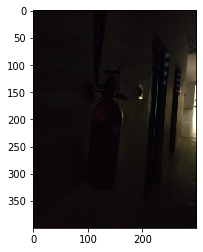

In [202]:
plt.imshow(raw_image)

0.06586786787217602


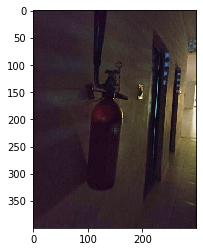

In [207]:
output = LIME(raw_image, alpha = 0.1, epsilon = 0.2, weight_strategy = 1)
plt.imsave('t4-alpha-10_epsilon-20_w-1.jpg',output)
plt.imshow(output)

In [185]:
output = LIME(output, alpha = 0.1, epsilon = 0.1, weight_strategy = 2)
plt.imsave('worst_case_2.jpg',output)
plt.imshow(output)

KeyboardInterrupt: 

0.1676686795571359


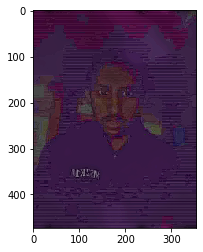

In [168]:
output = LIME(output, alpha = 0.1, epsilon = 0.1, weight_strategy = 2)
plt.imsave('worst_case_3.jpg',output)
plt.imshow(output)

0.2528018509892832


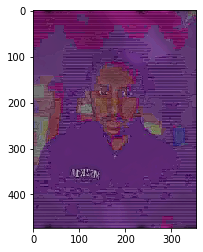

In [169]:
output = LIME(output, alpha = 0.1, epsilon = 0.1, weight_strategy = 2)
plt.imsave('worst_case_4.jpg',output)
plt.imshow(output)